In [1]:
import pandas as pd
import psycopg2
from causalimpact import CausalImpact
import warnings
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
warnings.simplefilter('ignore')
from creds import db_password, brand_name, account_id

conn = psycopg2.connect(dbname="market_data", user = "postgres", host="localhost", password=db_password, port = "5432")

In [2]:
sql = f"""
select
	date,
	sum(coalesce(conversions,0)) filter (where campaign_name like '%Conversion' and adgroup_name like '%_Boston%') as boston,
	sum(coalesce(conversions,0)) filter (where campaign_name like '%Conversion' and adgroup_name like '%_Minnea%') as minneapolis,
	sum(coalesce(conversions,0)) filter (where campaign_name like '%Conversion' and adgroup_name like '%_Washi%') as washington,
	sum(coalesce(conversions,0)) filter (where campaign_name like '%Conversion' and adgroup_name like '%_Phila%') as philadelphia,
	sum(coalesce(conversions,0)) filter (where campaign_name like '%Conversion' and adgroup_name like '%_Trist%') as tristate,
	sum(coalesce(conversions,0)) filter (where campaign_name like '%Conversion' and adgroup_name like '%_Chic%') as chicago

from(
	select * from facebook_prod.{brand_name}_standard as fds
	left join (
		select
			fda.ad_id,
			fda.account_id,
			fda.date as conv_date,
			fda.count_1dc as conversions
		from facebook.fact_daily_actions as fda
		where account_id = {account_id}
			and fda.date >= '2024-04-01'
			and fda.date < '2024-07-01'
			and fda.action_name = 'offsite_conversion.custom.437086748964880'
		) as convs on (convs.ad_id, convs.conv_date) = (fds.ad_id, fds.date)
	where fds.date >= '2024-04-01' and fds.date < '2024-07-01'
	and campaign_name like '2025_Consumer%') as ad
group by date
"""

In [3]:
source_data = pd.read_sql(sql, conn)
source_data['date'] = pd.to_datetime(source_data['date'])
source_data = source_data.set_index('date')
source_data.head(3)

,boston,minneapolis,washington,philadelphia,tristate,chicago
date,,,,,,
2024-04-01,0,0,0,0,0,0
2024-04-02,0,0,0,0,0,0
2024-04-03,2,1,0,1,2,2


In [4]:
test_config = {
    'boston':{
        'pre':['2024-04-01', '2024-04-14'],
        'post':['2024-04-15', '2024-04-30'],
        'y':'boston'
        },
    'philadelphia':{
        'pre':['2024-05-01', '2024-05-14'],
        'post':['2024-05-15', '2024-05-31'],
        'y':'philadelphia'
        },
    'minneapolis':{
        'pre':['2024-04-15', '2024-04-30'],
        'post':['2024-05-01', '2024-05-15'],
        'y':'minneapolis'
        },
    'washington':{
        'pre':['2024-05-15', '2024-05-31'],
        'post':['2024-06-01', '2024-06-15'],
        'y':'washington'
        }
}

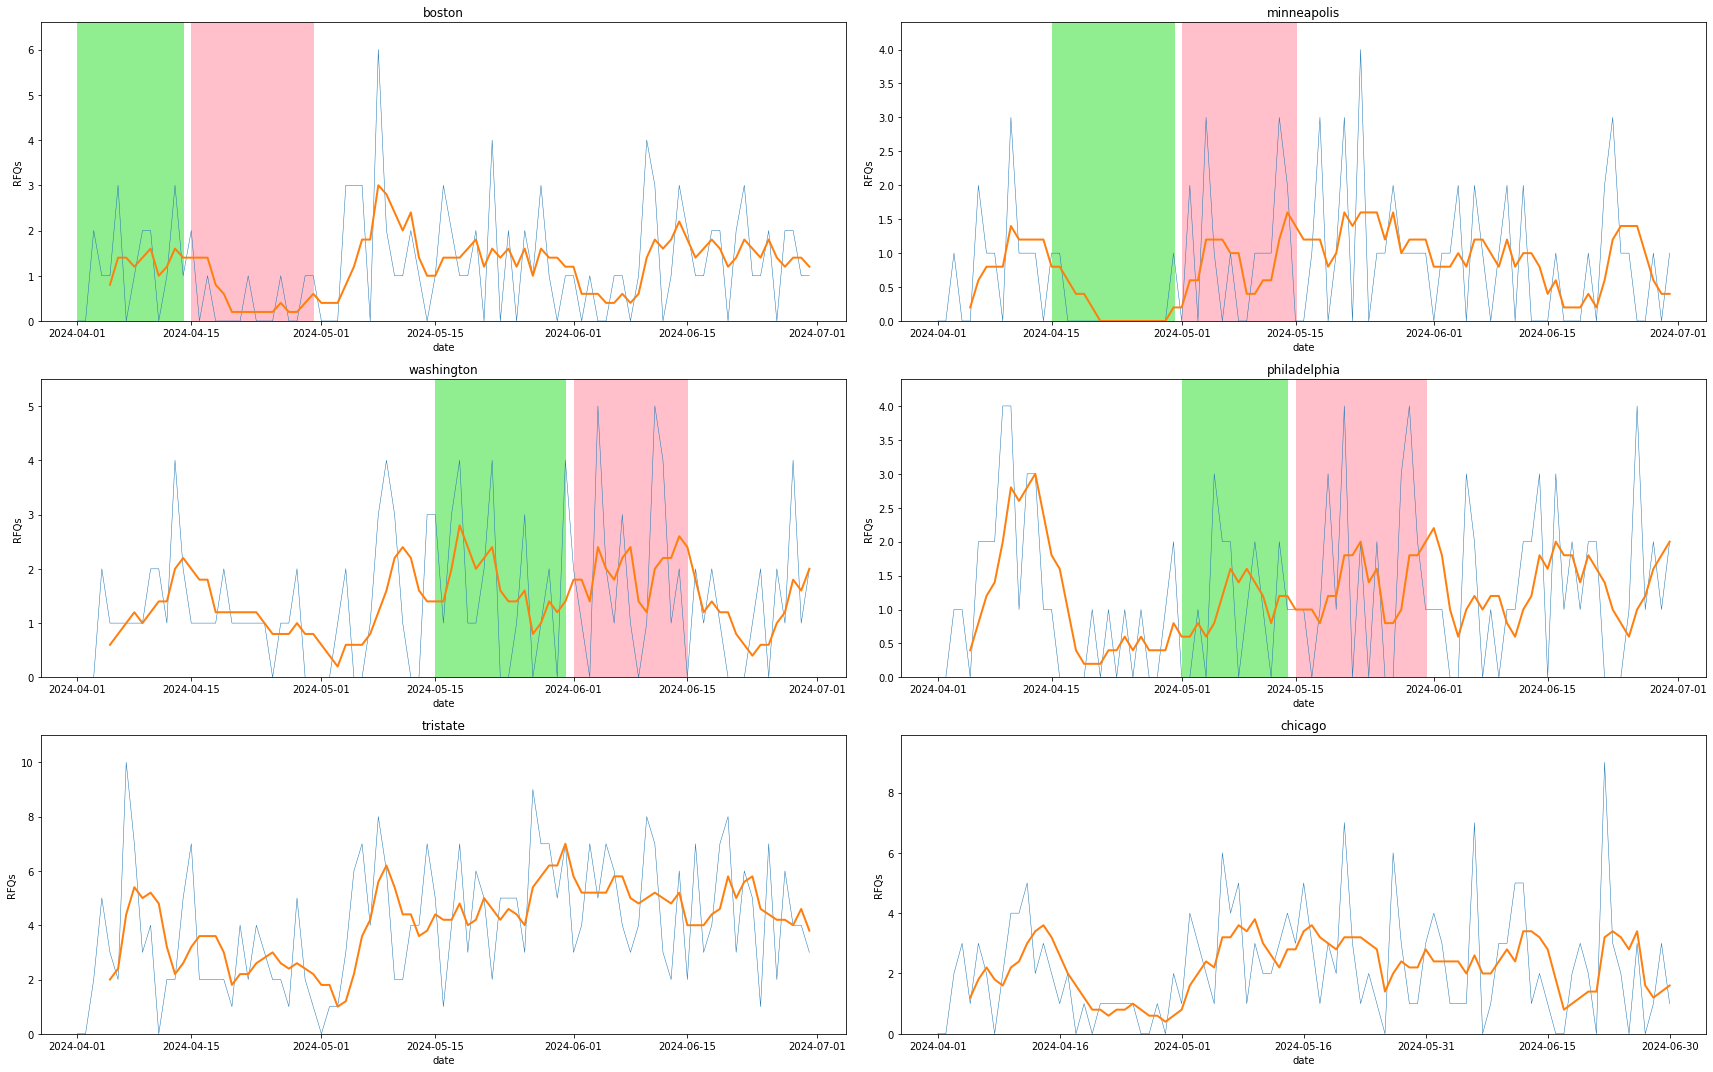

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 15))

def plot_market_lines(ax_row=None, ax_col=None, market=None):
    axes[ax_row, ax_col].plot(source_data[market], linewidth=0.5)
    axes[ax_row, ax_col].plot(source_data[market].rolling(5).mean(), linewidth=2)
    axes[ax_row, ax_col].set_ylabel('RFQs')
    axes[ax_row, ax_col].set_xlabel('date')
    axes[ax_row, ax_col].set_title(market)
    axes[ax_row, ax_col].set_ylim(0, source_data[market].max()*1.1)
    if ax_row < 2:
        axes[ax_row, ax_col].axvspan(test_config[market]['post'][0], test_config[market]['post'][1],color='pink')
        axes[ax_row, ax_col].axvspan(test_config[market]['pre'][0], test_config[market]['pre'][1],color='lightgreen')

counter = 0
for i in range(3):
    for j in range(2):
        plot_market_lines(i,j,source_data.describe().columns[counter])
        counter += 1
plt.xticks(source_data.index[::15])
fig.tight_layout()
fig.show()


In [6]:
source_data = source_data.rename(columns={'chicago':'x1','tristate':'x2'})
source_data['control_totals'] = source_data['x1'] + source_data['x2']


In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np
for market_result in source_data.describe().columns:
    sc = StandardScaler()
    source_data[market_result] = sc.fit_transform(np.array(source_data[market_result]).reshape(-1, 1))

In [8]:
def run_test(market=None):
    test_data = source_data[[market, 'x1', 'x2']]
    ci = CausalImpact(test_data, test_config[market]['pre'], test_config[market]['post'], niter=2000)
    print(f'Model P-Value is: {ci.p_value}')
    print(f"Post period prediction: {float(ci.summary_data.loc['predicted']['cumulative'])}")
    print(f"Post period actual: {float(ci.summary_data.loc['actual']['cumulative'])}")
    # print(f"Predicted intervention absolute effect: {float(ci.summary_data.loc['abs_effect']['cumulative'])}")
    # print(f"Predicted intervention relative effect: {float(ci.summary_data.loc['rel_effect']['cumulative'])}")
    print(f"Post period actual - pred: {float(ci.summary_data.loc['actual']['cumulative'] - ci.summary_data.loc['predicted']['cumulative'])}")
    print(f"Correlation between test and control is {np.corrcoef(source_data.loc[test_config[market]['pre'][0]:test_config[market]['pre'][1]][market],source_data.loc[test_config[market]['pre'][0]:test_config[market]['pre'][1]]['control_totals'])[0,1]}")
    # print(ci.summary(output='report'))
    ci.plot()

In [9]:
def differences(market=None, sample_df=None):
    test1 = source_data.loc[test_config[market]['pre'][0]:test_config[market]['pre'][1]][market].mean()
    test2 = source_data.loc[test_config[market]['post'][0]:test_config[market]['post'][1]][market].mean()
    test_diff_abs = test2 - test1
    control1 = source_data.loc[test_config[market]['pre'][0]:test_config[market]['pre'][1]]['control_totals'].mean()
    control2 = source_data.loc[test_config[market]['post'][0]:test_config[market]['post'][1]]['control_totals'].mean()
    cont_diff_abs = control2 - control1

    diff_df = pd.DataFrame({
        'entries':['test', 'control'],
        'pre_mean':[test1, control1],
        'post_mean':[test2, control2],
        'mean_diff_abs': [test_diff_abs, cont_diff_abs],
        'mean_diff_rel':[test2 / test1, control2 / control1]
    })
    print(diff_df.head())
    DiD = diff_df.loc[0]['mean_diff_abs'] - diff_df.loc[1]['mean_diff_abs'] 

    # pass lift back to the plotting function for control group
    control_lift = cont_diff_abs #absolute
    # control_lift = control2 / control1
    print(f"DID:  {DiD}")

    df_1 = source_data.loc[test_config[market]['pre'][0]:test_config[market]['pre'][1]].reset_index()
    df_1['g0'] = 0
    df_1['g1'] = 1
    pre_results = pd.concat([df_1[market], df_1['control_totals']], ignore_index=True)
    pre_gs = pd.concat([df_1['g1'], df_1['g0']], ignore_index=True)
    df_pre = pd.DataFrame({
        'results':pre_results,
        'g':pre_gs,
        't':[0 for x in range(len(pre_results))]
    })

    df_2 = source_data.loc[test_config[market]['post'][0]:test_config[market]['post'][1]].reset_index()
    df_2['g0'] = 0
    df_2['g1'] = 1
    post_results = pd.concat([df_2[market], df_2['control_totals']], ignore_index=True)
    post_gs = pd.concat([df_2['g1'], df_2['g0']], ignore_index=True)
    df_post = pd.DataFrame({
        'results':post_results,
        'g':post_gs,
        't':[1 for x in range(len(post_results))]
    })

    df_reg = pd.concat([df_pre, df_post], ignore_index=True)
    df_reg['gt'] = df_reg['g'] * df_reg['t']
    # print(df_reg.head(10))
    lr = ols('results ~ g + t + gt', data=df_reg).fit()
    print(lr.summary())
    gt_coef = lr.params['gt']
    gt_pvalue = lr.pvalues['gt']
    if sample_df == True:
        print('Sample of DF for DiD Model')
        print(df_reg.head())
    print(f"Coefficient for 'gt': {gt_coef:.4f}")
    print(f"P-Value for 'gt': {gt_pvalue:.4f}")
    output_df = diff_df[['pre_mean', 'post_mean']]


    return output_df, control_lift


In [10]:
def plot_did(output=None):
    plot_df = output[0].transpose()
    plot_df['pred'] = [plot_df.loc['pre_mean'][0], plot_df.loc['pre_mean'][0] + output[1]] #Edit last modifier for + or *

    fig, ax = plt.subplots()
    ax.plot(plot_df[0], label='Test')
    ax.plot(plot_df[1], label='Control')
    ax.plot(plot_df['pred'], label='Pred', linestyle='--')

    plt.legend()
    plt.show()

Boston Results

Model P-Value is: 0.06693306693306693
Post period prediction: -2.5786123580854743
Post period actual: -10.320136368798941
Post period actual - pred: -7.7415240107134675
Correlation between test and control is 0.061555434528861475


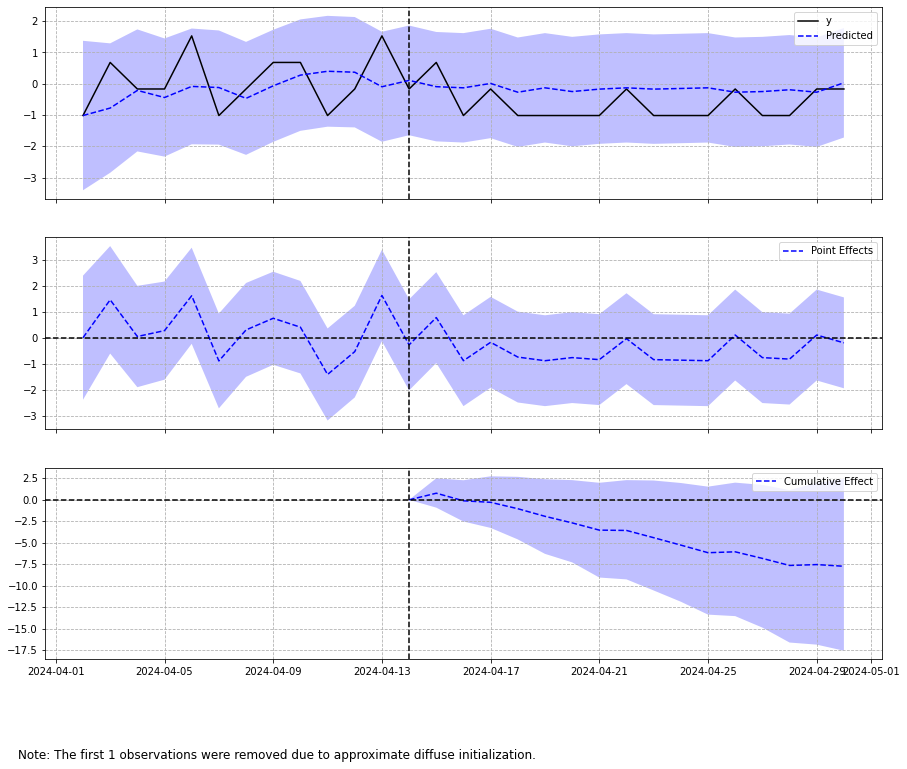

In [11]:
run_test('boston')

   entries  pre_mean  post_mean  mean_diff_abs  mean_diff_rel
0     test  0.013984  -0.645009      -0.658992      -46.12500
1  control -0.248521  -0.845992      -0.597471        3.40411
DID:  -0.06152118804595885
                            OLS Regression Results                            
Dep. Variable:                results   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     3.727
Date:                Fri, 13 Sep 2024   Prob (F-statistic):             0.0163
Time:                        06:02:38   Log-Likelihood:                -67.701
No. Observations:                  60   AIC:                             143.4
Df Residuals:                      56   BIC:                             151.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                       

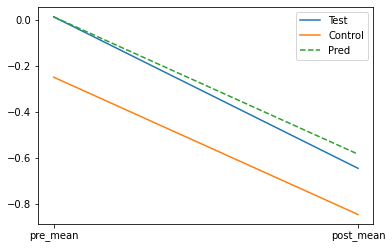

In [12]:
plot_did(differences('boston', sample_df=True))

Minneapolis Results

Model P-Value is: 0.054945054945054944
Post period prediction: 0.45301827711938497
Post period actual: 3.318893322860387
Post period actual - pred: 2.865875045741002
Correlation between test and control is 0.36605332565193793


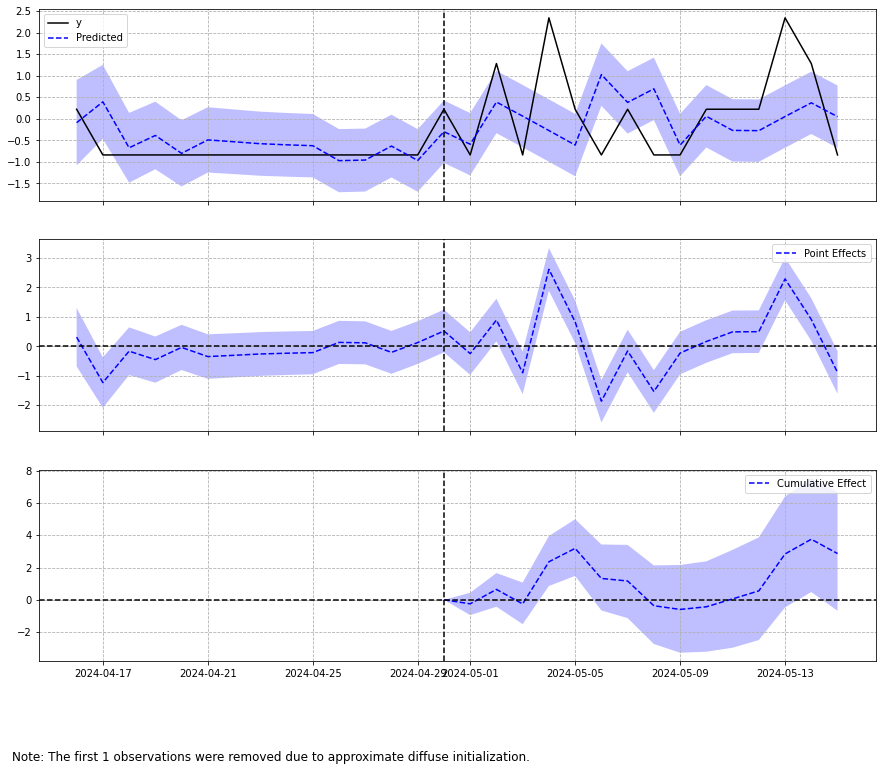

In [13]:
run_test('minneapolis')

   entries  pre_mean  post_mean  mean_diff_abs  mean_diff_rel
0     test -0.639760   0.221260       0.861020      -0.345848
1  control -0.845992   0.217654       1.063646      -0.257277
DID:  -0.20262645340896457
                            OLS Regression Results                            
Dep. Variable:                results   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     6.803
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           0.000524
Time:                        06:02:42   Log-Likelihood:                -75.692
No. Observations:                  62   AIC:                             159.4
Df Residuals:                      58   BIC:                             167.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                       

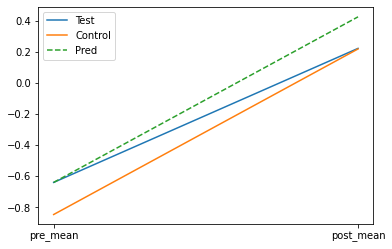

In [14]:
plot_did(differences('minneapolis'))

Philadelphia Results

Model P-Value is: 0.22377622377622378
Post period prediction: -0.08253754400943472
Post period actual: 3.688386235696596
Post period actual - pred: 3.7709237797060307
Correlation between test and control is 0.22605848366159456


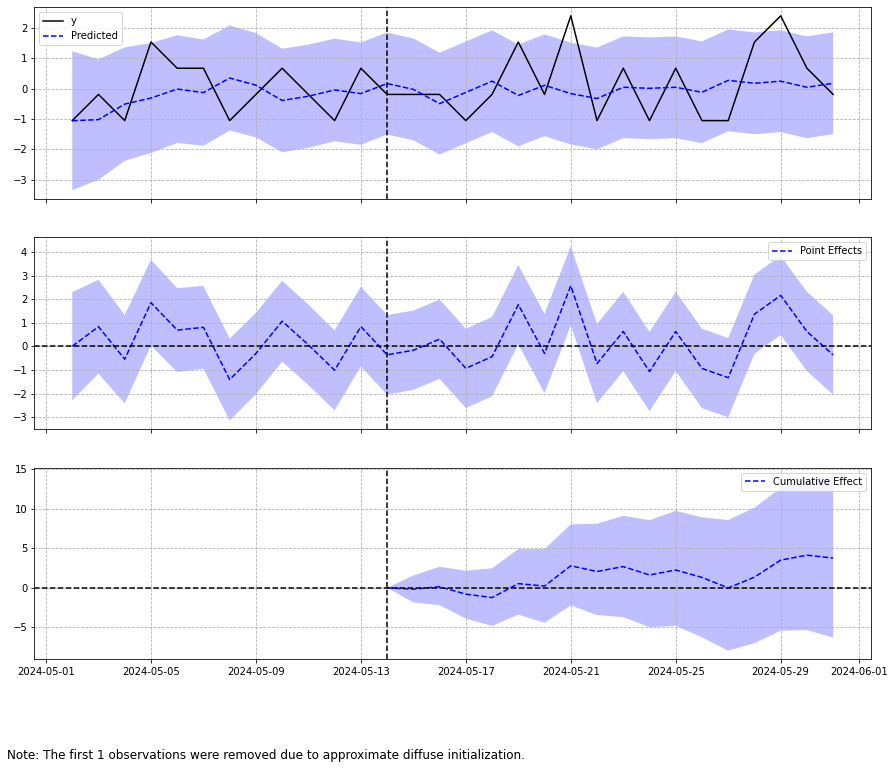

In [15]:
run_test('philadelphia')

   entries  pre_mean  post_mean  mean_diff_abs  mean_diff_rel
0     test -0.128333   0.216964       0.345297      -1.690632
1  control  0.194050   0.456990       0.262939       2.355005
DID:  0.08235750101320505
                            OLS Regression Results                            
Dep. Variable:                results   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.8572
Date:                Fri, 13 Sep 2024   Prob (F-statistic):              0.469
Time:                        06:02:47   Log-Likelihood:                -86.691
No. Observations:                  62   AIC:                             181.4
Df Residuals:                      58   BIC:                             189.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                        

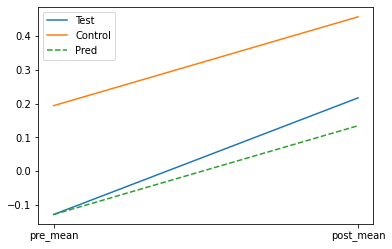

In [16]:
plot_did(differences('philadelphia'))

Washington Results

Model P-Value is: 0.46553446553446554
Post period prediction: 4.610025030741179
Post period actual: 5.412184488614532
Post period actual - pred: 0.8021594578733531
Correlation between test and control is -0.13723719394128076


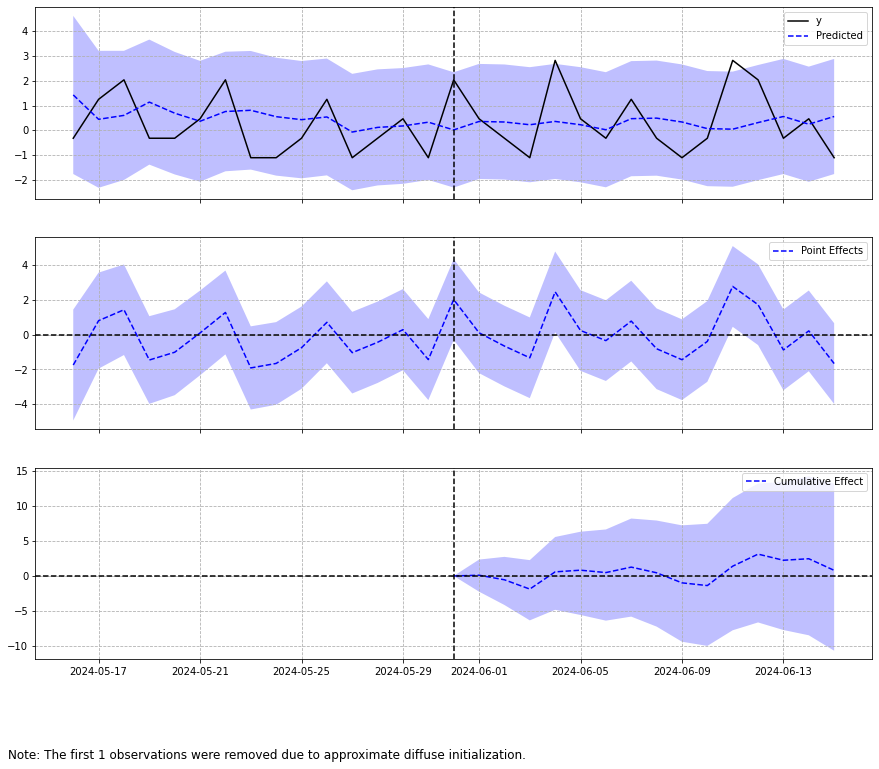

In [17]:
run_test('washington')

   entries  pre_mean  post_mean  mean_diff_abs  mean_diff_rel
0     test   0.28085   0.360812       0.079963       1.284717
1  control   0.45699   0.320921      -0.136069       0.702249
DID:  0.21603169188474552
                            OLS Regression Results                            
Dep. Variable:                results   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                   0.08140
Date:                Fri, 13 Sep 2024   Prob (F-statistic):              0.970
Time:                        06:02:51   Log-Likelihood:                -94.046
No. Observations:                  64   AIC:                             196.1
Df Residuals:                      60   BIC:                             204.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                        

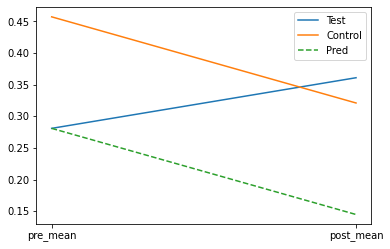

In [18]:
plot_did(differences('washington'))